In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [3]:
def prepare_data(dataframe: pd.DataFrame):
    # Features to del
    features_to_del = ['Perimeter', 'MajorAxisLength', 
                       'MinorAxisLength', 'ConvexArea', 
                       'EquivDiameter', 'AspectRation', 
                       'Eccentricity', 'ShapeFactor3'
                       ]

    abod_detector = ABOD(contamination=0.05, n_neighbors=20, method='fast')
    outliers = abod_detector.fit_predict(dataframe.drop(["Class"], axis=1).to_numpy())
    df_with_detected_outliers = pd.concat([dataframe, pd.DataFrame(outliers, columns=["is_outlier"])], axis=1)
    df_cleaned = df_with_detected_outliers[df_with_detected_outliers["is_outlier"] == 0]
    df_cleaned = df_cleaned.drop(features_to_del, axis=1).drop(["is_outlier"], axis=1)
    scaler = MinMaxScaler()
    df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])
    return df_cleaned

In [4]:
df = pd.read_excel("../../data/Dry_Bean_Dataset.xlsx")
df_cleaned = prepare_data(df)
df_cleaned.head()

/Users/nikolajfonov/Programming/GitRepositories/comparison-of-bayesian-classifiers/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/var/folders/nm/_vhgd_nn6_q6j0v7y5gyx2p40000gn/T/ipykernel_31907/749219750.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04352619 0.0453764  0.04890216 ... 0.11853861 0.11858227 0.11864777]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])


,Area,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,0.043526,0.671024,0.838660,0.922035,0.786733,0.573722,0.828019,0.971414,SEKER
1,0.045376,0.735504,0.725580,0.752553,0.903549,0.525508,0.966331,0.963094,SEKER
2,0.048902,0.716671,0.859193,0.897738,0.773514,0.561753,0.794945,0.981113,SEKER
3,0.052330,0.731365,0.483377,0.792905,0.829912,0.530710,0.850368,0.843167,SEKER
4,0.053050,0.700538,0.898182,0.986134,0.951583,0.487023,1.000000,0.983945,SEKER


In [5]:
x = df_cleaned.drop(["Class"], axis=1).to_numpy()
y = df_cleaned["Class"].to_numpy()
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear"]

In [6]:
class Kernel:
    _kernels: list[KernelDensity]

    def __init__(self, kernel_type, bandwidth, dim):
        self._kernels = []
        for _ in range(dim):
            self._kernels.append(KernelDensity(kernel=kernel_type, bandwidth=bandwidth))
    
    def fit(self, x):
        for i in range(len(self._kernels)):
            self._kernels[i].fit(x[:,i].reshape((-1, 1)))
        
    def predict(self, x):
        result = []
        for i in range(len(self._kernels)):
            result.append(np.exp(self._kernels[i].score_samples(x[:,i].reshape((-1, 1)))))
        return np.array(result).T
    
    def predict_part(self, x, kde_num):
        return np.exp(self._kernels[kde_num].score_samples(x.reshape((-1, 1))))
    
    @property
    def dim(self):
        return len(self._kernels)

# Nonparametric Bayes

Rule:
$$k^*=\arg\max_{k=\overline{1,K}}\tilde f_X(x|k)\tilde p_Y(k)$$
where:
- $\tilde p_Y(k) = \frac{n_y}{n}$;
- $ \tilde f(x)=\prod_{j=1}^M\tilde f_j(x_j)=\frac{1}{n^Mh_1*...*h_M}\prod_{j=1}^M\sum_{i=1}^nK(\frac{x_j-x_{ji}}{h_j})$;
- K – kernel.

In [144]:
# Nonparametric Bayes
class BayesianNonparametricalModel:
    _kernel_class: KernelDensity
    _kernel_params: dict
    _kernel_instances: dict[str: KernelDensity]
    _klass_probabilities: np.array
    _classes: np.array


    def __init__(self, kernel: KernelDensity, kernel_params: dict) -> None:
        self._kernel_class = kernel
        self._kernel_params = kernel_params
        self._kernel_instances = {}

    def fit(self, x, y) -> None:
        if x.shape[0] != y.shape[0]:
            raise Exception
        
        self._classes, counts = np.unique(y, return_counts=True)
        klass_probs = counts / np.sum(counts)
        self._klass_probabilities = {self._classes[i]: klass_probs[i] for i in range(len(klass_probs))}

        for klass in self._classes:
            klass_indexes = np.where(y == klass)
            x_k = x[klass_indexes]
            y_k = y[klass_indexes]
            
            kernel_k = self._kernel_class(**self._kernel_params)
            kernel_k.fit(x_k)
            self._kernel_instances[klass] = kernel_k
            
    
    def predict_proba(self, x) -> np.array:
        probs_arr = []
        for klass in self._classes:
            f_xk = np.exp(self._kernel_instances[klass].score_samples(x))
            f_k = self._klass_probabilities[klass]
            p_k = f_xk * f_k
            probs_arr.append(p_k)
        probs_arr = np.array(probs_arr).T # [[first element], ... , [last element]]
        probs = probs_arr / probs_arr.sum(axis=1)[:, None]
        return probs

    def predict(self, x) -> np.array:
        probs = self.predict_proba(x)
        indexes_max_elements = probs.argmax(axis=1)
        return self._classes[indexes_max_elements]

In [177]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

kernel = KernelDensity
kernel_params = {
    "kernel": "epanechnikov",
    "bandwidth": 'silverman'
}
bnm = BayesianNonparametricalModel(kernel, kernel_params)
bnm.fit(X_train, y_train)

In [178]:
from sklearn.metrics import accuracy_score


pred = bnm.predict(X_test)
accuracy_score(y_test, pred)

0.6768221232716194

In [ ]:
class NPBayes:
    _kernel: Kernel

    def __init__(self, kernel_type, bandwidth, dim):
        self._kernel = Kernel(kernel_type, bandwidth, dim)
    
    def fit(self, x, y):
        self._kernel.fit(x)
        kde_dens = self._kernel.predict(x)
        self._clf.fit(kde_dens, y)
    
    def predict(self, x):
        kde_dens = self._kernel.predict(x)
        return self._clf.predict(kde_dens)

In [ ]:
class NPBayes:
    _kernel: Kernel
    _clf: GaussianNB

    def __init__(self, kernel_type, bandwidth, dim):
        self._kernel = Kernel(kernel_type, bandwidth, dim)
        self._clf = GaussianNB()
    
    def fit(self, x, y):
        self._kernel.fit(x)
        kde_dens = self._kernel.predict(x)
        self._clf.fit(kde_dens, y)
    
    def predict(self, x):
        kde_dens = self._kernel.predict(x)
        return self._clf.predict(kde_dens)

In [8]:
clf = NPBayes("epanechnikov", 'silverman', x.shape[1])
clf.fit(x, y)
pred = clf.predict(x)

KeyboardInterrupt: 

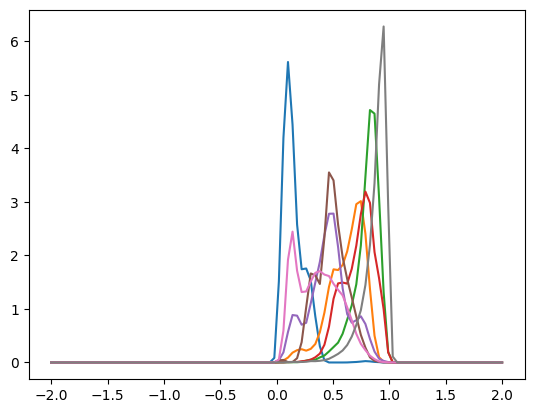

In [144]:
kernel = Kernel("linear", 'silverman', x.shape[1])
kernel.fit(x)
t = np.repeat(np.linspace(-2, 2, 100), kernel.dim).reshape(-1, kernel.dim)
kde_pred = kernel.predict(t)

plt.plot(t, kde_pred)
plt.show()

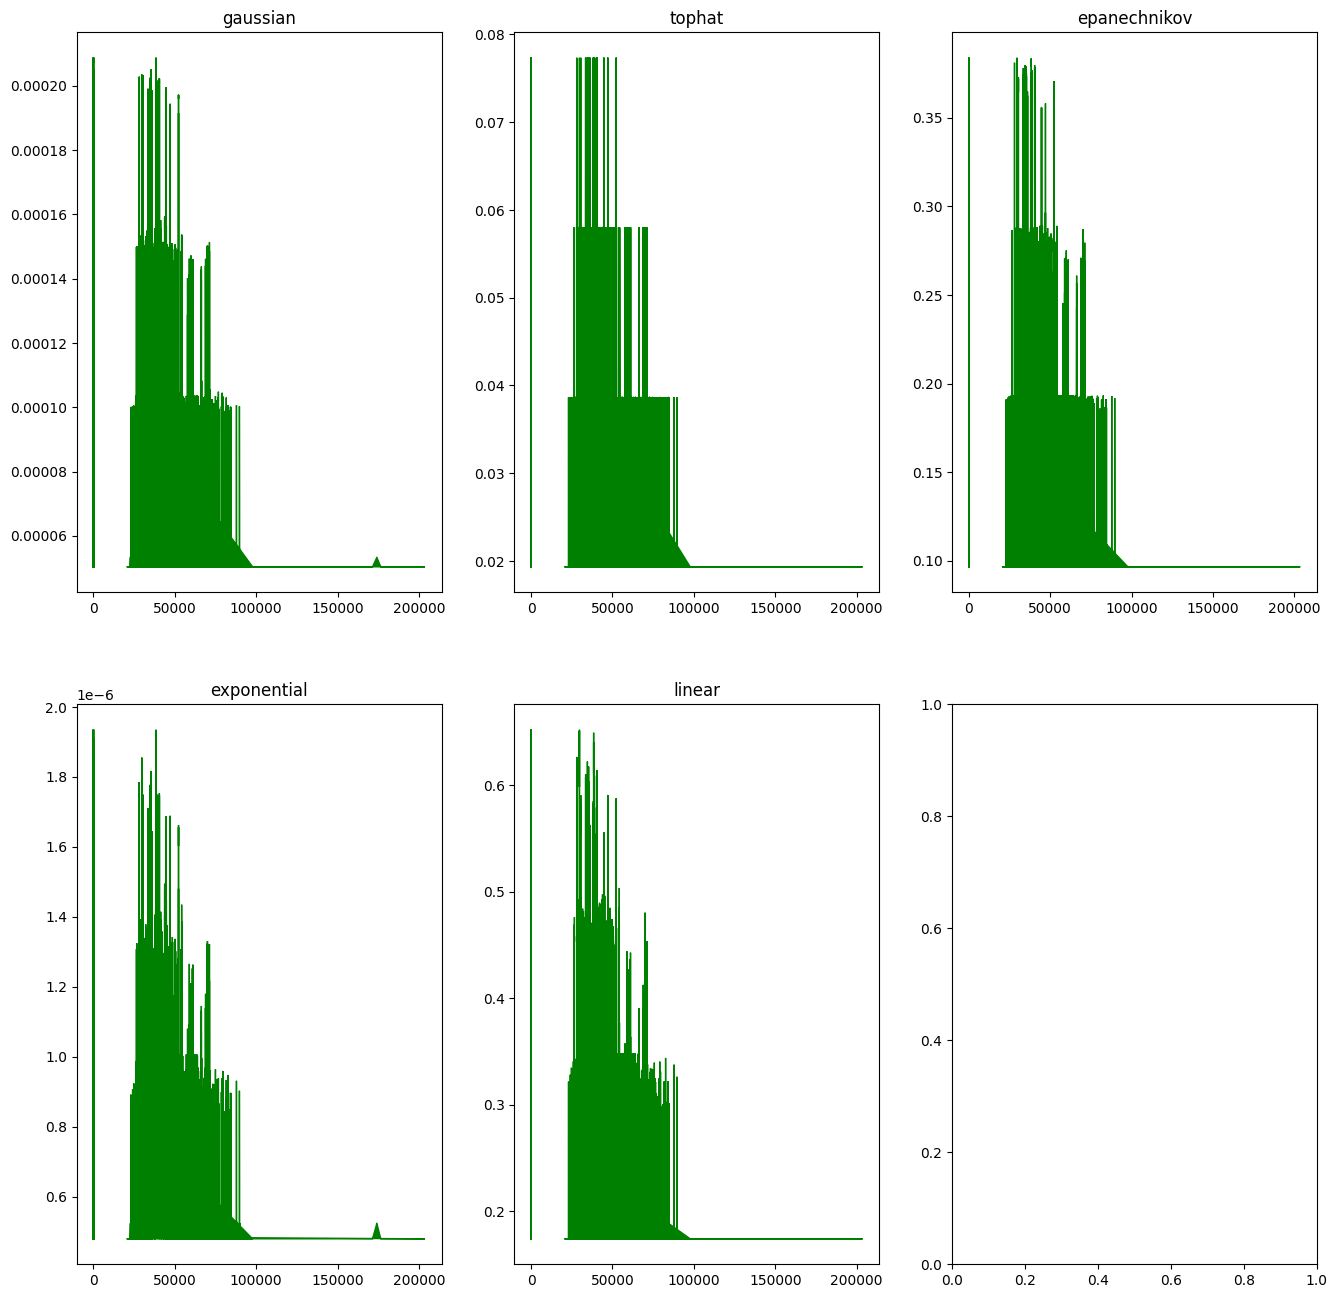

In [5]:
def plot_distribution_kernel(kernels):
    fig, ax = plt.subplots(2, 3, figsize=(16, 16))
    for i, kernel in enumerate(kernels):
        
        kde = KernelDensity(kernel=kernel, bandwidth="silverman").fit(x)
        log_dens = kde.score_samples(x)
        #print(i // 3, i % 3)
        ax[i // 3][i % 3].fill(x, np.exp(log_dens), c='green')
        ax[i // 3][i % 3].set_title(kernel)
    plt.show()

plot_distribution_kernel(kernels=kernels)

In [81]:


def get_std_mean(kernels):
    res_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for i, (train_index, test_index) in enumerate(kf.split(x)):
            kde = KernelDensity(kernel=kernel, bandwidth="silverman").fit(x)
            dens = np.exp(kde.score_samples(x)).reshape((-1, 1))
            gnb = GaussianNB().fit(dens[train_index], y[train_index])
            res_dict[kernel].append(accuracy_score(gnb.predict(dens[test_index]), y[test_index]))
    return res_dict

res = get_std_mean(kernels=kernels)

In [82]:
pd.DataFrame(res).describe().loc[["mean", "std"]]

,gaussian,tophat,epanechnikov,exponential,linear
mean,0.158082,0.069838,0.071926,0.262800,0.073318
std,0.011327,0.008298,0.007273,0.020236,0.006270


In [89]:
def get_std_mean(kernels, bandwith):
    res_mean_dict = {kernel: [] for kernel in kernels}
    res_std_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for bw in bandwith:
            bw_res = []
            for i, (train_index, test_index) in enumerate(kf.split(x)):
                kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x)
                dens = np.exp(kde.score_samples(x)).reshape((-1, 1))
                gnb = GaussianNB().fit(dens[train_index], y[train_index])
                bw_res.append(accuracy_score(gnb.predict(dens[test_index]), y[test_index]))
            res_mean_dict[kernel].append(np.mean(bw_res))
            res_std_dict[kernel].append(np.std(bw_res))
    return res_mean_dict, res_std_dict

to_test = [0.5, 1, 2, 4, 8, 16]
res = get_std_mean(kernels=kernels, bandwith=to_test)

In [118]:
def plot_bandwith_cmp(bandwiths, bandwiths_values, name):
    fig, ax = plt.subplots(2, 3, figsize=(16, 16))
    fig.suptitle(name, fontsize=20)
    for i, bandwith in enumerate(bandwiths.keys()):
        ax[i // 3][i % 3].plot(bandwiths_values, bandwiths[bandwith], c='green')
        ax[i // 3][i % 3].set_title(bandwith)
    
    plt.show()

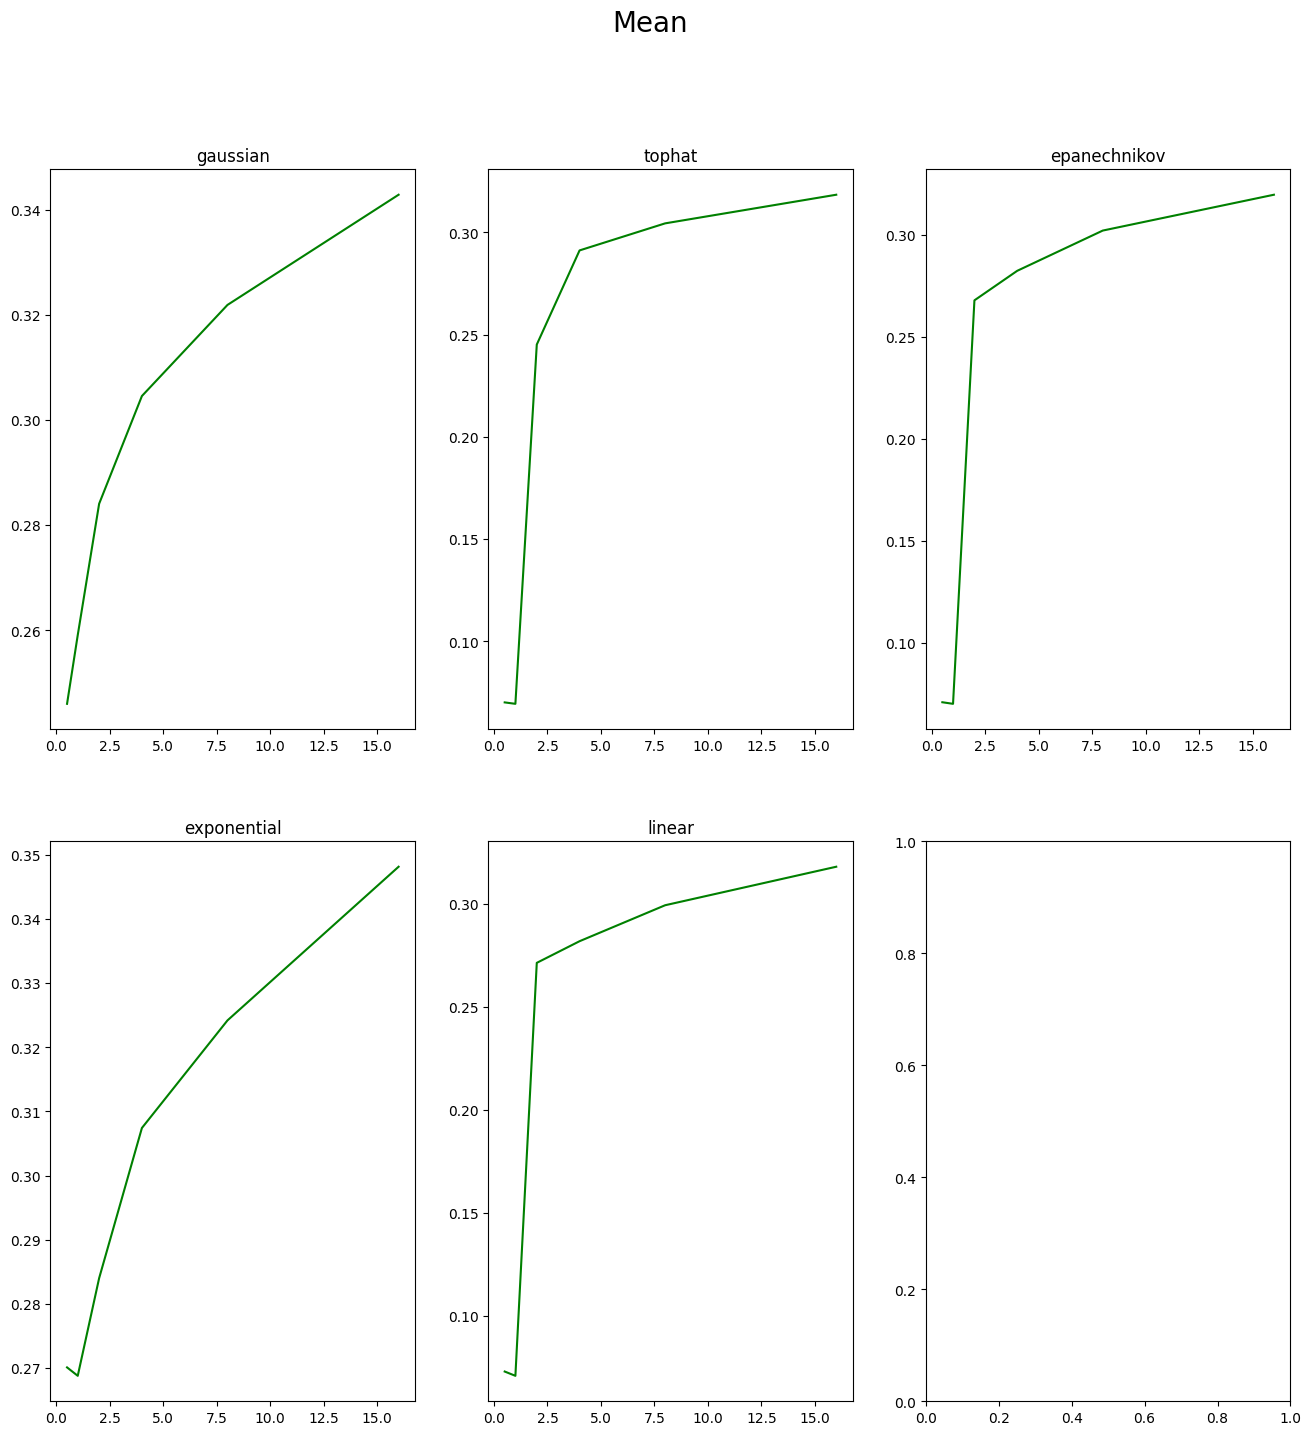

In [119]:
# Mean bandwith
to_test = [0.5, 1, 2, 4, 8, 16]
plot_bandwith_cmp(res[0], to_test, "Mean")

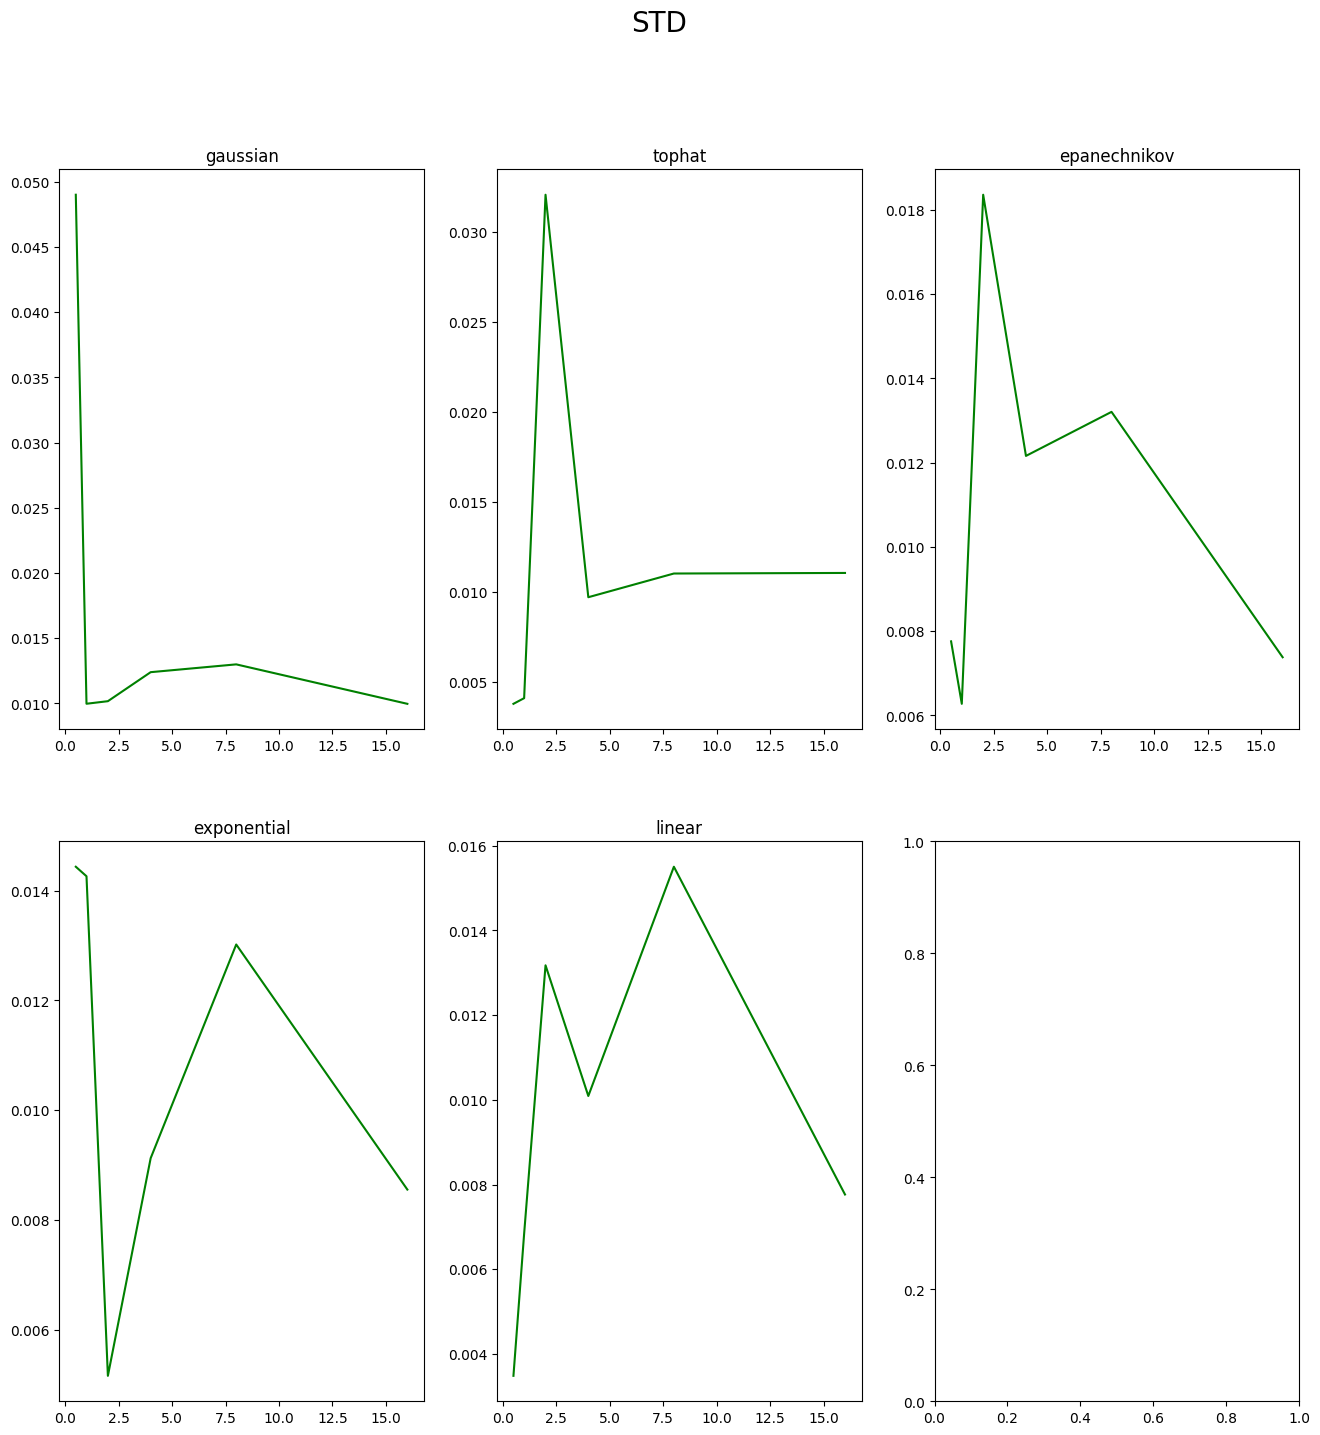

In [120]:
# STD bandwith
to_test = [0.5, 1, 2, 4, 8, 16]
plot_bandwith_cmp(res[1], to_test, "STD")

The classifier has the greatest generalizing function when the window width is equal to 16

array([5, 5, 5, ..., 3, 3, 3])